In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

2021.07.06

通过python脚本绘制时间、纬向剖面

前处理部分，将所有降水变量处理问统一的坐标（来自CN05.1）

合并到 var 字典之中，用作后续的绘图

remains：
- 调整色标
- 将时间ticks旋转下

In [2]:
# dir_in = "/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA/mask_pre/mask_res_dayofyear/"
dir_in = "/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA_large/pre/ydaymean/"
# filename_cn051  = "ydaymean_mask_sel_CN05.1_Pre_1961_2018_daily_025x025.nc"
filename_obs      = "obsmerge_pre_98-17.nc"
# filename_cmorph = "ydaymean_mask_sel_CMORPH_98-17.nc"
# filename_vr     = "ydaymean_mask_vr_pre_98-17.nc"
# filename_rcm    = "ydaymean_mask_rcm_pre_98-17.nc"
filename_vr       = "vr_pre_98-17.nc"
filename_rcm      = "rcm_pre_98-17.nc"


ds_or = {}
# ds_or['cn051']  = xr.open_dataset(dir_in + filename_cn051)
# ds_or['cmorph'] = xr.open_dataset(dir_in + filename_cmorph)
ds_or['obs']  = xr.open_dataset(dir_in + filename_obs)
ds_or['vr']     = xr.open_dataset(dir_in + filename_vr)
ds_or['rcm']    = xr.open_dataset(dir_in + filename_rcm  )
# 提取变量
var = {}
# var['cn051'] = ds_or['cn051']['pre']
# var['cmorph'] = ds_or['cmorph']['cmorph'][:, 0, :, :]
var['obs'] = ds_or['obs']['premerge']
var['obs'] = var['obs'].reset_coords(names = 'lev', drop = True) # 去除掉obs中多余的lev coords
var['vr'] = ds_or['vr']['precip_MPAS']
var['rcm'] = ds_or['rcm']['precip_MPAS']
# change coords
# var_list = ['cn051','cmorph', 'vr', 'rcm']
var_list = ['obs', 'vr', 'rcm']
for i in var_list:
    rename_dict = dict(zip(var[i].coords.keys(), var['obs'].coords.keys()))
    # show converting coords
    for rename_i in rename_dict:
        print(rename_i + " -----converting to----- " + rename_dict[rename_i])

    var[i] = var[i].rename(rename_dict)
    var[i]._coords = var['obs']._coords
    var[i] = var[i].rename(i)


time -----converting to----- time
lon -----converting to----- lon
lat -----converting to----- lat
Time -----converting to----- time
longitude -----converting to----- lon
latitude -----converting to----- lat
Time -----converting to----- time
longitude -----converting to----- lon
latitude -----converting to----- lat


In [3]:
region_dict = {}
lat = var['obs'].lat
lon = var['obs'].lon
time= var['obs'].time
region_dict['lat'] = lat[(lat>=5) & (lat<=60)]
region_dict['lon'] = lon[(lon>=105) & (lon<=125)]
var_lattime = {}
for ivar in var.keys():
    var_lattime[ivar] = var[ivar].sel(region_dict).mean('lon')

## 修改色板

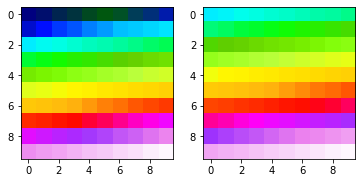

In [4]:
# 调整cmap，去掉gist_ncar 中深蓝色的部分
# https://stackoverflow.com/questions/18926031/how-to-extract-a-subset-of-a-colormap-as-a-new-colormap-in-matplotlib

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import cmaps

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

arr = np.linspace(0, 50, 100).reshape((10, 10))
fig, ax = plt.subplots(ncols=2)

cmap = plt.get_cmap('gist_ncar')
# cmap = cmaps.gui_default
new_cmap = truncate_colormap(cmap, 0.2, 1.)
ax[0].imshow(arr, interpolation='nearest', cmap=cmap)
ax[1].imshow(arr, interpolation='nearest', cmap=new_cmap)
plt.show()

In [5]:
mean_ticks = np.concatenate((np.linspace(2,16,29), np.linspace(18,22,2)), axis=0)
mean_ticks

array([ 2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,  6.5,  7. ,
        7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5, 12. , 12.5,
       13. , 13.5, 14. , 14.5, 15. , 15.5, 16. , 18. , 22. ])

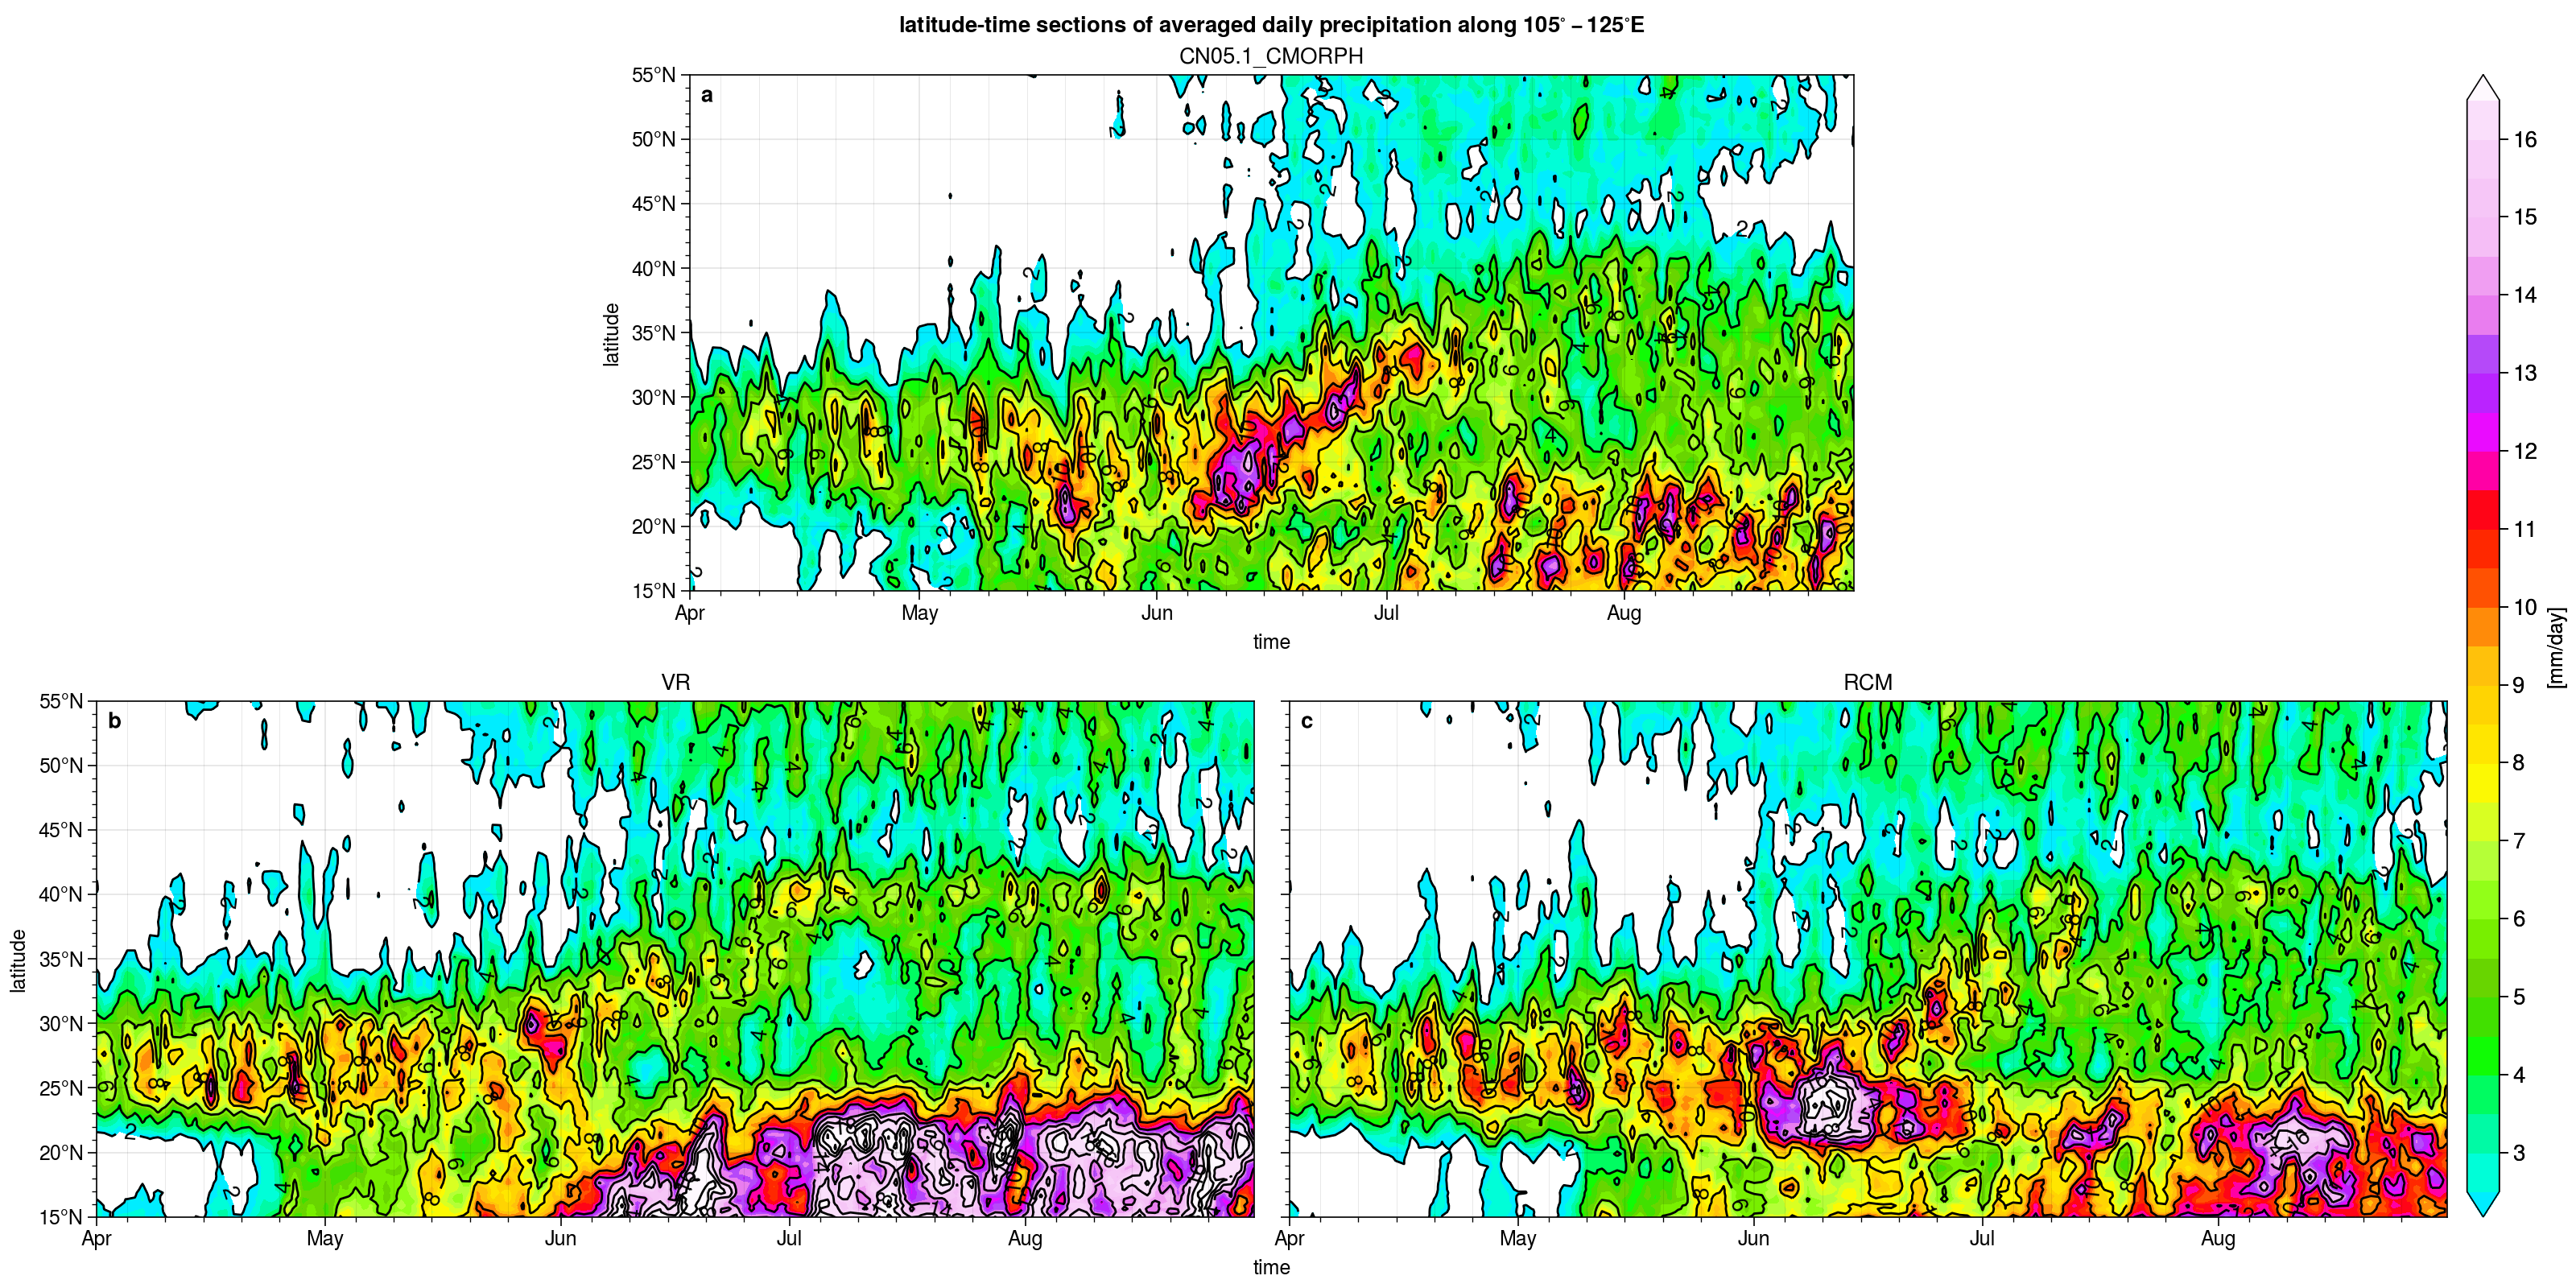

In [6]:
# import proplot as plot
from matplotlib import pyplot as plt
import proplot as plot
# ----- get filter vars coords-----

cmap=new_cmap
# cmap="tab20"

lat_sel  = var_lattime['obs'].lat
# time_sel = var_lattime['obs'].time.dt.strftime("%m-%d")
time_sel = var_lattime['obs'].time.values

# ticks = np.arange(4,25,1.)
# ticks = np.arange(4,20,.5)
ticks_contour = np.arange(0,30,2.)
ticks = mean_ticks
#----- create plot -----
shapearray=[[0,1,1,0],[2,2,3,3]]
fig, axs = plot.subplots(shapearray,figsize=(16,8))

#-----2012-----
axs[0].format(title='CN05.1_CMORPH')
# axs[1].format(title='CMORPH')
axs[1].format(title='VR')
axs[2].format(title='RCM')
# m = axs[0].contour(lon_sel, time_sel, var_lattime['obs'],\
# levels=ticks,color='k',
# linewidth = .5)
for i, ivar in enumerate(var_list):
    m_overlay = axs[i].contourf(time_sel,  lat_sel, var_lattime[ivar].values.T, cmap=cmap,\
    levels=ticks)
    m_contour = axs[i].contour(time_sel,  lat_sel, var_lattime[ivar].values.T,\
    levels=ticks_contour,linewidth=1,color='k')
    axs[i].clabel(m_contour, inline=True, fontsize=10, colors = 'k', fmt='%2.0f',use_clabeltext=True, inline_spacing=0)
# format作为整个proplot集中对属性进行修改的method
axs.format(
abc=True, abcloc='ul',

yformatter='deglat',
ylim=(15,55),
ylabel='latitude',

# xlocator='weekday',
# xlocator=('month', [4,5,6,7,8]),
# xminorlocator='day',
# xformatter='%m-%d',
xrotation=0,  # rotated time ticks
xlabel='time',
xminorlocator=('day',range(0,30,5)),
xlocator=('month',range(0,12,1)),
xformatter = '%b', #title='Ticks every N units',
xgridminor = True,

suptitle="latitude-time sections of averaged daily precipitation along " + r"$105^{\circ} -125^{\circ} E$"
)

# for tick in axs.get_xticklabels():
    # tick.set_rotation(45)
#----- add contour tick labels -----
fig.colorbar(m_overlay, loc='r', length = 1., width=0.2,extend='both', label='[mm/day]',
ticklabelsize=10,ticks=ticks[::2])

fig.patch.set_facecolor('white')
# plt.savefig('./output_pic/precip_98-17_lat-time_large_py.png', dpi=600, facecolor= "white")